Copyright 2025 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<font color='green' size=16>Run CISC and Evaluate</font>

This simple notebook runs a model locally to generate answers and confidence score for CISC and compares it to self consistency.

# Setup

In [ ]:
# @title Imports

import copy
import dataclasses
import datetime
import os

from cisc.src import confidence_extraction
from cisc.src import run_lib as run_lib
from cisc.src.post_processing import aggregators
from cisc.src.post_processing import run_eval_lib
from cisc.src.runners import batcher as batcher_lib
from cisc.src.runners import hugging_face_runner

In [ ]:
# @title Load the Model

# The name or the path to an hugging face model.
model_str = "google/gemma-2-2b-it"
hf_runner = hugging_face_runner.Runner(model_str)
_MAX_BATCH_SIZE_GEMMA = 500  # This worked with H100. Try smaller for less VRAM.
runner = batcher_lib.BatchRunner(
    hf_runner,
    batch_size=_MAX_BATCH_SIZE_GEMMA,
    max_wait_time_secs=1,
)

In [ ]:
%%time

# @title Run The Model { form-width: "25%"}

num_traces = 8  # @param {'type': 'number'}
num_rows = 100  # @param {'type': 'number'}
max_num_tokens = 756  # @param {'type': 'number'}
temp = 0.9  # @param
max_workers_stage1 = 2  # @param {'type': 'number'}
# More workers as batch size must be 1 here.
max_workers_stage2 = 120  # @param {'type': 'number'}
tag = "gemma2_local"  # @param {'type': 'string'}

# Dataset choices are ["MMLU", "GSM8K", "MATH"]
dataset_names = ["BBH"]  # @param

# Extract the three type of confidence scores report in the paper.
confidence_config = confidence_extraction.AggregatedConfidenceExtractionConfig(
    verbal_confidence=confidence_extraction.ConfidenceExtractionType.NONE.value,  # HUNDRED.value,
    confidence_likelihoods=confidence_extraction.ConfidenceExtractionType.BINARY.value,
    run_sequence_probability=False,
)

config = run_lib.ExperimentConfiguration(
    num_traces,
    num_rows,
    max_num_tokens=max_num_tokens,
    temperature=temp,
    tag=tag,
    confidence_config=confidence_config,
)

output_base_dir = os.path.join("/tmp/cisc/", tag)
output_base_dir_versioned = os.path.join(
    output_base_dir, datetime.datetime.now().strftime("%Y_%m_%d_%H:%M")
)

all_datasets_results = []
# First generate the answers.
all_datasets_results.extend(
    run_lib.run_question_answering_on_datasets(
        runner,
        dataset_names,
        config=config,
        max_workers=max_workers_stage1,
        output_base_dir=output_base_dir_versioned,
    )
)
# all_datasets_results = run_lib.load_all_experiment_results(dir_name=output_base_dir)

# Next, extract the confidence for each answer.
output_base_dir = os.path.join(output_base_dir, "confidence")
output_base_dir_versioned = os.path.join(
    output_base_dir, datetime.datetime.now().strftime("%Y_%m_%d_%H:%M")
)
all_datasets_results = run_lib.run_confidence_extraction_on_experiment_results(
    runner,
    all_datasets_results,
    config.confidence_config,
    max_workers=max_workers_stage2,
    output_base_dir=output_base_dir_versioned,
)
# all_datasets_results = run_lib.load_all_experiment_results(dir_name=output_base_dir)

In [ ]:
# @title Compute Metrics

aggregator_configs = [
    aggregators.AggregatorConfig(
        aggregator_type=aggregators.AggregatorType.SC,
        norm_type=aggregators.NormalizationType.NONE,
    ),
    aggregators.AggregatorConfig(
        aggregator_type=aggregators.AggregatorType.CISC,
        norm_type=aggregators.NormalizationType.SOFTMAX,
        temperature=0.2,  # This value is taken from the CISC paper.
        confidence_col_name="logit_confidence",  # P(True) in the paper.
    ),
]
TRACES_LENS = range(1, num_traces + 1)
return_per_question_scores = True  # @param {'type': 'boolean'}
datasets_stats = {}
for ds in all_datasets_results:
  dataset_name = ds.dataset_name
  datasets_stats[dataset_name] = (
      run_eval_lib.calculate_stats_for_model_and_dataset(
          tag,
          ds,
          dataset_name,
          filter_answers=False,
          round_negative_conf_to_zero=False,
          re_compute_is_correct=True,
          aggregator_configs=aggregator_configs,
          traces_lens=TRACES_LENS,
          num_bootstrap=500,
          # Return the score per question. Aggregate latter, in the next cell.
          return_per_question_scores=return_per_question_scores,
      )
  )

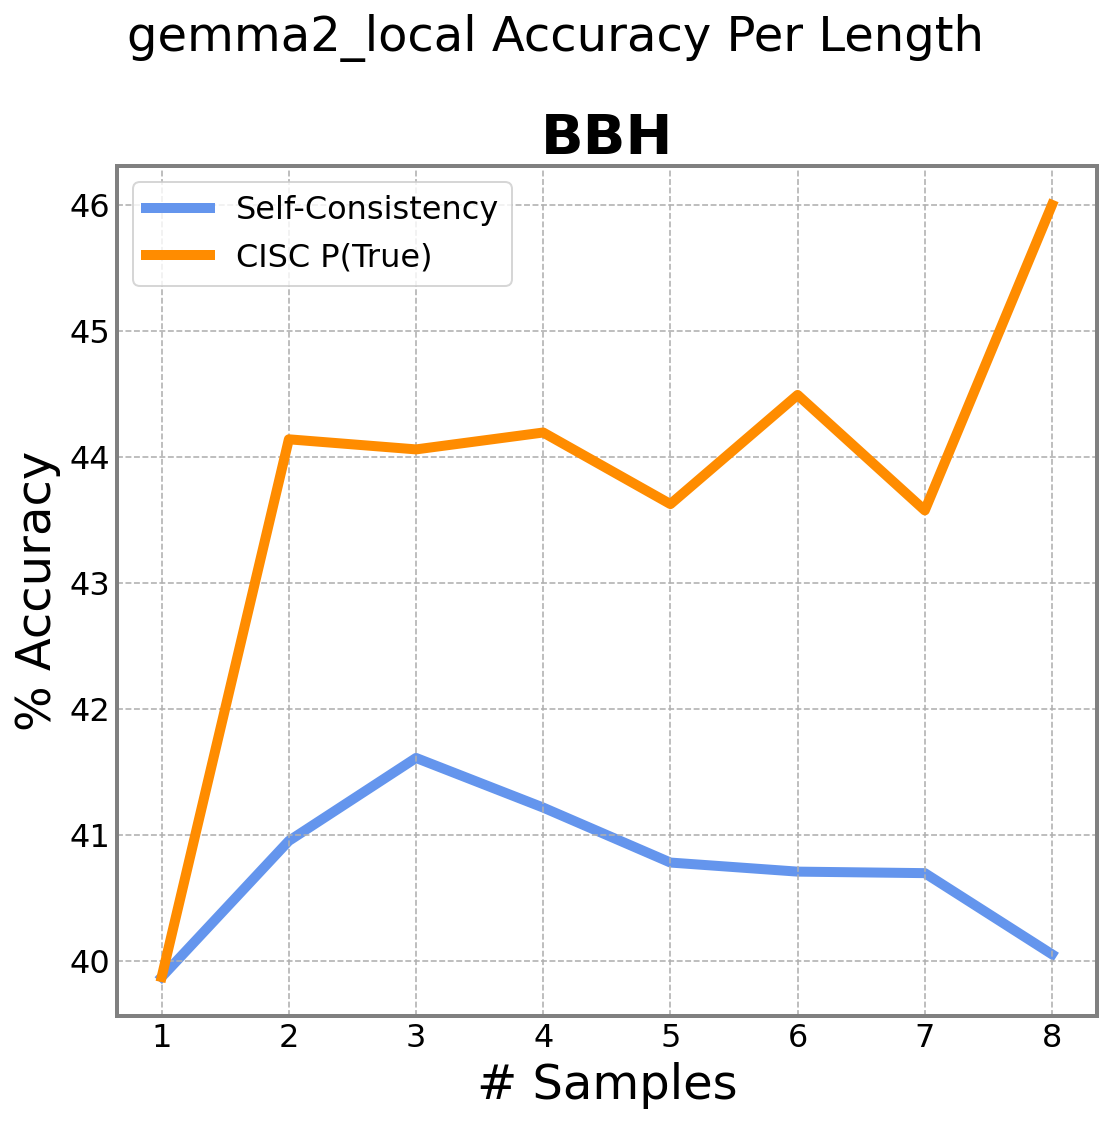

In [ ]:
# @title Draw Graphs { vertical-output: true, form-width: "30%" }
import copy
import dataclasses
import numpy as np


def get_method_display_names_dict(break_type='\n'):
  return {
      'verbal_confidence': f'Verbal{break_type}0-100',
      'logit_confidence': 'P(True)',
      'response_probability': f'Response{break_type}Probability',
      'binary_confidence': 'Verbal Binary',
  }


def aggregate_over_questions(raw_stats):
  raw_stats = copy.deepcopy(raw_stats)
  for _, dataset_stats in raw_stats.items():
    score_stats = dataset_stats.score_stats
    updated_stats = {}
    for k, v in score_stats.items():
      updated_stats[k] = np.array(v).mean(axis=1)
    dataset_stats.score_stats = updated_stats
  return raw_stats


NEED_AGGREGATE_OVER_QUESTIONS = True  # @param {'type': 'boolean'}
if NEED_AGGREGATE_OVER_QUESTIONS:
  processed_stats = aggregate_over_questions(datasets_stats.copy())
else:
  processed_stats = datasets_stats

target_keys = [
    'SC_NONE',
    'CISC_verbal_confidence',
    'CISC_logit_confidence',
    'CISC_response_probability',
    'CISC_binary_confidence',
]


def rename_metrics(
    data_to_update: dict,
    prefixes_to_keep: list[str],
):
  """Rename the metric to only include the prefixes of `target_keys`"""
  data_to_update = copy.deepcopy(data_to_update)
  for _, dataset_stats in data_to_update.items():
    updated_score_stats = {}
    for method, method_stats in dataset_stats.score_stats.items():
      for key in prefixes_to_keep:
        if method.startswith(key):
          updated_name = key
          updated_score_stats[updated_name] = method_stats
          break
    dataset_stats.score_stats = updated_score_stats
  return data_to_update


processed_stats = rename_metrics(processed_stats, target_keys)

# @title draw graphs


@dataclasses.dataclass
class LabelSettings:
  display_name: str
  line_type: str
  color: str
  line_width: int
  # If true would draw an horizontal at the height of the last value.
  horizontal_line: bool = False


labels = {
    'SC_NONE': LabelSettings(
        'Self-Consistency', 'solid', 'cornflowerblue', 5, False
    ),
    'CISC_logit_confidence': LabelSettings(
        'CISC P(True)', 'solid', 'darkorange', 5
    ),
    'CISC_response_probability': LabelSettings(
        'CISC Response Probability', (0, (3, 2)), 'crimson', 5
    ),
    'CISC_verbal_confidence': LabelSettings(
        'CISC Verbal 1-100', (0, (3, 2)), 'turquoise', 5
    ),
    'CISC_binary_confidence': LabelSettings(
        'CISC Binary', (0, (3, 2)), 'darkviolet', 5
    ),
}

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})


def draw_cisc(per_ds_stats, model_name, traces_lens=TRACES_LENS):
  i = 0
  # per_ds_stats = {'MATH': per_ds_stats['MATH']}
  num_cols = len(per_ds_stats)
  fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(8 * num_cols, 8))
  fig.suptitle(f'{model_name} Accuracy Per Length', fontsize=24)
  for dataset_name, stats in per_ds_stats.items():
    stats = stats.score_stats
    ax = axes[i] if num_cols > 1 else axes
    ax.set_title(dataset_name, fontsize=28, weight='semibold')
    j = 1
    for label, vals in stats.items():
      if label not in labels:
        continue
      label = labels[label]
      ax.plot(
          traces_lens[:30],
          [v * 100 for v in vals[:10]],
          linestyle=label.line_type,
          linewidth=label.line_width,
          label=label.display_name,
          color=label.color,
          zorder=j,
          markersize=10,
      )
      if label.horizontal_line:
        ax.axhline(
            y=vals[-1] * 100,
            color='mediumseagreen',
            linestyle='dashed',
            linewidth=4,
            xmin=0.26,
            xmax=0.96,
            marker='s',
            markersize=6,
            zorder=999,
        )
      ax.set_xlabel('# Samples', fontsize=24)
      ax.set_ylabel('% Accuracy', fontsize=24)
      ax.xaxis.set_tick_params(size=0)
      ax.yaxis.set_tick_params(size=0)
      for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_edgecolor('grey')

      ax.grid('on', linestyle='--')
      j += 1
    ax.legend(fontsize=16)
    i += 1
  fig.tight_layout()


draw_cisc(processed_stats, tag)

In [ ]:
# @title Within Question Discrimination - Breakdown { vertical-output: true, form-width: "30%" }

import pandas as pd

CONFIDENCE_TYPE = "logit_confidence"  # @param ['logit_confidence', 'verbal_confidence', 'binary_confidence', 'response_probability']


def get_wqd_df(raw_stats, confidence_type):
  data = []

  for dataset, dataset_stats in raw_stats.items():
    cur_stats = dataset_stats.confidence_methods_stats[confidence_type].wqd_eval
    score = 0
    if cur_stats.num_pairs > 0:
      score = (
          cur_stats.num_higher_better + cur_stats.num_confidence_ties * 0.5
      ) / (cur_stats.num_pairs)
    data.append({
        "Model": tag,
        "Dataset": dataset,
        "score": score,
        "higher_cnt": cur_stats.num_higher_better,
    })
  df = pd.DataFrame(data)
  df = df.pivot(index="Model", columns="Dataset", values=["score"])
  return df


df = get_wqd_df(processed_stats, CONFIDENCE_TYPE)
df

,score
Dataset,BBH
Model,
gemma2_local,0.627708
